<a href="https://colab.research.google.com/github/dmika1234/dl_uwr/blob/develop/Assignments/Assignment3/colab_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports, settings

In [3]:
%pylab inline
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

Populating the interactive namespace from numpy and matplotlib


In [75]:
# Torch has to go first due to an importing bug
import collections
import logging
import os
import re

import httpimport
import numpy as np
import PIL
import scipy.io
import scipy.ndimage
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.autograd import Variable
# import torch.utils.data as data

logging.getLogger("PIL").setLevel(logging.INFO)

# Colab
# %load_ext autoreload
# %autoreload
with httpimport.github_repo(
     "dmika1234", "dl_uwr", "develop"
):
     from Assignments.Assignment3.funs import VGG, VGGPreprocess, ILSVRC2014Sample, to_tensor, to_np, obscured_imgs, discrete_cmap, SubsampledImageDataset, compute_error_rate, plot_history, train
with httpimport.github_repo(
    "janchorowski", "nn_assignments", "nn18"
):
    import common.plotting

ImportError: ignored

In [5]:
# On GPU enabled devices set device='cuda' else set device='cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CUDA = device.type == 'cuda'
CUDA

True

In [6]:
![ -e ilsvrc_subsample.tar.bz2 ] || gdown 'https://drive.google.com/uc?id=1Y9xfTe9rjvFiX5N9DZqCRm83zHtQUBDC' -O ilsvrc_subsample.tar.bz2
![ -d ilsvrc_subsample ] || tar jxf ilsvrc_subsample.tar.bz2

Downloading...
From: https://drive.google.com/uc?id=1Y9xfTe9rjvFiX5N9DZqCRm83zHtQUBDC
To: /content/ilsvrc_subsample.tar.bz2
100% 25.5M/25.5M [00:00<00:00, 98.4MB/s]


# Loading VGG model

In [7]:
vgg = VGG("vgg19")
if CUDA:
    vgg.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 80.5MB/s]


In [8]:
# List layers in the model
print("Feature layers")
print("--------------")
for name, layer in zip(vgg.feature_names, vgg.features):
    print("{1: <12} {0: <8}  ({2}".format(name, *str(layer).split("(", 1)))
print("\nClassifier layers")
print("-----------------")
for layer in vgg.classifier:
    print("{: <12}({}".format(*str(layer).split("(", 1)))

Feature layers
--------------
Conv2d       conv1_1   (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_1   (inplace=True)
Conv2d       conv1_2   (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_2   (inplace=True)
MaxPool2d    pool1     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv2_1   (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_1   (inplace=True)
Conv2d       conv2_2   (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_2   (inplace=True)
MaxPool2d    pool2     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv3_1   (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_1   (inplace=True)
Conv2d       conv3_2   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_2   (inplace=True)
Conv2d       conv3_3   (256, 256, kernel_size=(3, 3), stride

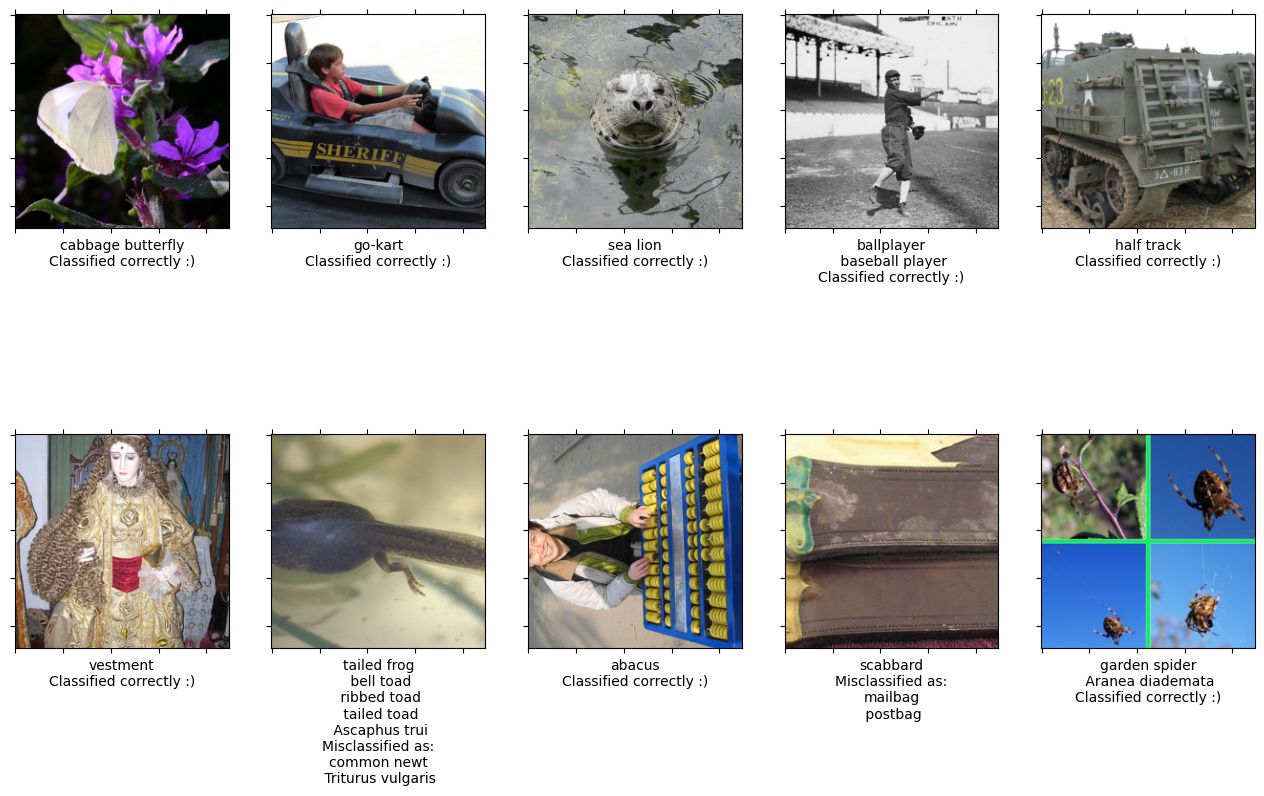

In [9]:
ilsvrc = ILSVRC2014Sample(40)
vgg.eval()

figsize(16, 10)
for i in range(10):
    img = ilsvrc.data[30 + i]
    label = ilsvrc.labels[30 + i]

    img_torch = to_tensor(img, cuda=CUDA)

    predicted_label_id = to_np(vgg.predict(img_torch)).reshape(-1)[0]
    predicted_label = ilsvrc.id_to_label[predicted_label_id]

    desc = ilsvrc.label_to_desc[label].split(",")
    if label == predicted_label:
        desc.append("Classified correctly :)")
    else:
        desc.append("Misclassified as:")
        desc.extend(ilsvrc.label_to_desc[predicted_label].split(","))

    ax = plt.subplot(2, 5, 1 + i)
    ax.set_xlabel("\n".join(desc))  # , {'verticalalignment': 'bottom'})
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)
    ax.tick_params(axis="both", which="both", bottom="off", left="off", top="off")
    ax.grid(False)
    plt.imshow(img)

# Problem 1

## 1.1 Implement classification of your own images below

In [ ]:
!gdown https://drive.google.com/drive/folders/1cTPDKYU331ymzyZr5JKOjfTULK53S-mi?usp=sharing --folder

Retrieving folder list
Processing file 1QpkvaWHQL5IsuaxT1TtAcdVsjIQU_f_9 dogfrog.jpg
Processing file 1ns-qDg6btjTe-0pr2qBOOSRwccYcCzhc kwiot.jpg
Processing file 16YW66EGLPBcAydbc4CTSr-jg6i1zAiJZ photo_1.jpg
Processing file 1j-iiMgB_ljuVNhjqhVE7AgPpz1h6MXX9 pigeonman.jpg
Processing file 1yA_Zihof_kUG297jQxNmg6a5sJ8NOuaY suzi.jpg
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1QpkvaWHQL5IsuaxT1TtAcdVsjIQU_f_9
To: /content/Sample_img/dogfrog.jpg
100% 56.5k/56.5k [00:00<00:00, 71.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ns-qDg6btjTe-0pr2qBOOSRwccYcCzhc
To: /content/Sample_img/kwiot.jpg
100% 923k/923k [00:00<00:00, 129MB/s]
Downloading...
From: https://drive.google.com/uc?id=16YW66EGLPBcAydbc4CTSr-jg6i1zAiJZ
To: /content/Sample_img/photo_1.jpg
100% 56.9k/56.9k [00:00<00:00, 137MB/s]
Downloading...
From: https://drive.google.com/uc?id=1j-iiMgB_ljuVNhjqhVE7AgPpz1h6MXX9


In [ ]:
sample_img_dir = 'Sample_img/'
sample_imgs = [f for f in os.listdir(sample_img_dir)]

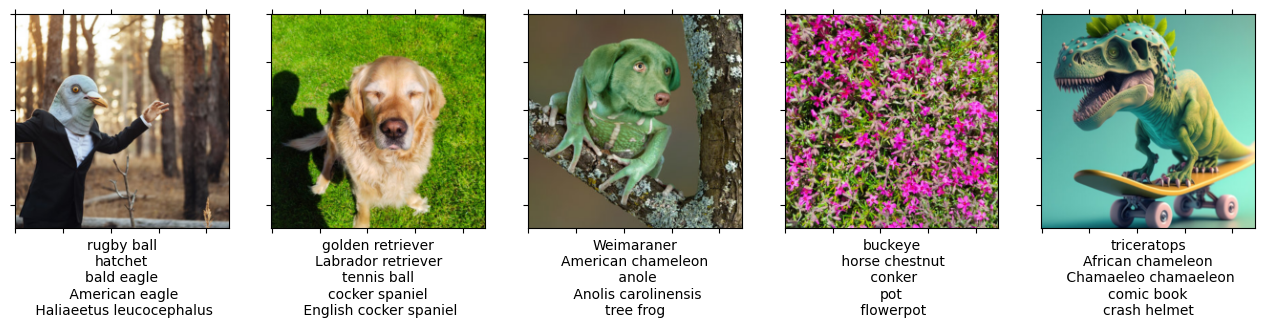

In [ ]:
figsize(16, 10)
i = 0
for sample_img in sample_imgs:
  img = ilsvrc.load_image(sample_img_dir + sample_img)
  img_torch = to_tensor(img, cuda=CUDA)

  predicted_label_id = to_np(vgg.predict(img_torch, k=5)).reshape(-1)
  predicted_labels = []
  for id in predicted_label_id:
    predicted_label = ilsvrc.id_to_label[id]
    predicted_labels.extend(ilsvrc.label_to_desc[predicted_label].split(","))
  predicted_labels = predicted_labels[0:5]

  ax = plt.subplot(2, 5, 1 + i)
  ax.set_xlabel("\n".join(predicted_labels))  # , {'verticalalignment': 'bottom'})
  ax.set_xticklabels([], visible=False)
  ax.set_yticklabels([], visible=False)
  ax.tick_params(axis="both", which="both", bottom="off", left="off", top="off")
  ax.grid(False)
  plt.imshow(img)
  i += 1

In [ ]:
ilsvrc.label_to_desc[predicted_label].split(",")[0]

'monitor'

## 1.2 Analyse the responses of the network when part of the input is obscured

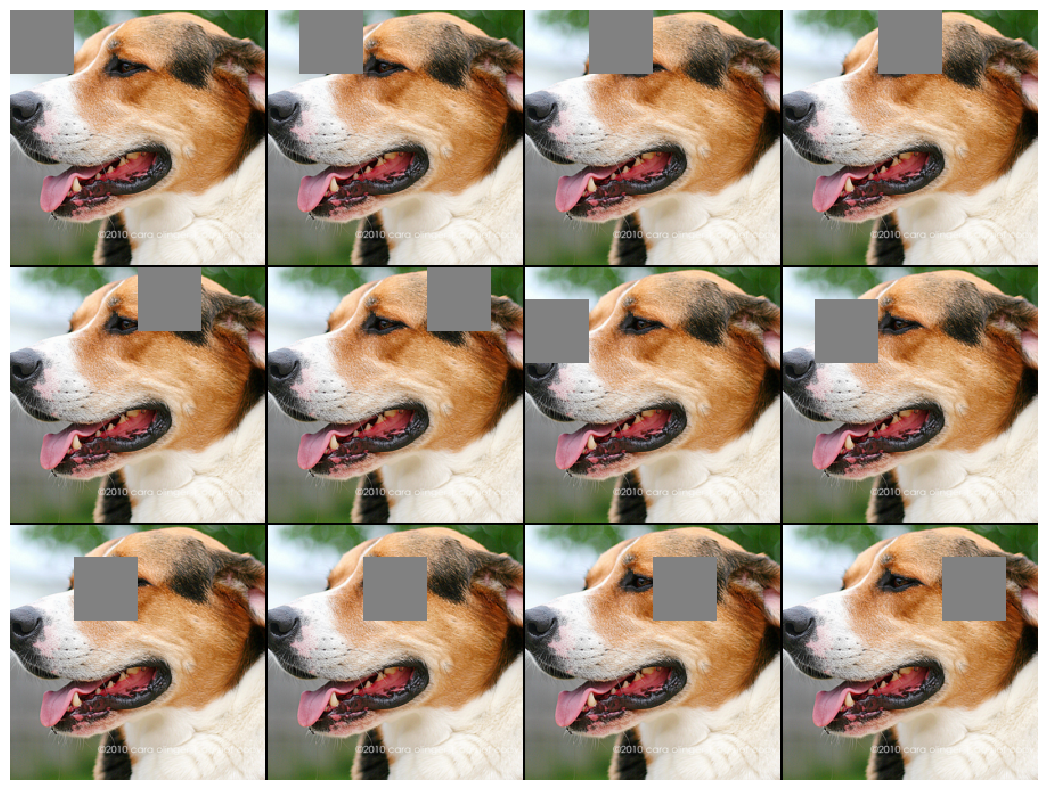

In [ ]:
# Show samples from an obscured batch
batch = next(obscured_imgs(ilsvrc.data[27], boxsize=56, bsz=12, stride=28))
batch = np.vstack([im[None] for im in batch])

common.plotting.plot_mat(batch.transpose(0, 3, 1, 2))

In [ ]:
idx = 32
img = ilsvrc.data[idx]
label = ilsvrc.labels[idx]

# if you run out of GPU mem split batch into smaller ones
bsz = 64
boxsize = 52
stride = 14

vgg.eval()

# Accumulate activations for activation heatmap,
# true class probability map, network prediction map
map_types = ["heat", "prob", "pred"]
maps = {mt: [] for mt in map_types}
for batch in obscured_imgs(img, boxsize, bsz, stride):
    with torch.no_grad():
        batch = to_tensor(np.array(batch), cuda=CUDA)
        # TODO choose a layer and a neuron. Aggregate its activations across all locations in the image
        # The sample code used layer conv2_1 and neuron #1
        maps["heat"].append(to_np(vgg.layer_activations(batch, "conv2_1"))[:, 1].sum(axis=(1, 2)))
        # TODO record the probability assigned to the correct class
        maps["prob"].append(to_np(vgg.probabilities(batch))[:, ilsvrc.label_to_id[label]])
        # TODO record the network predictions
        maps['pred'].append(to_np(vgg.predict(batch)))

for k in maps:
    maps[k] = np.concatenate(maps[k])
    maps[k] = maps[k].reshape(int(np.sqrt(maps[k].shape[0])), -1)

Text(0.5, 1.0, 'The most probable class as a function\nof the obscuring square location')

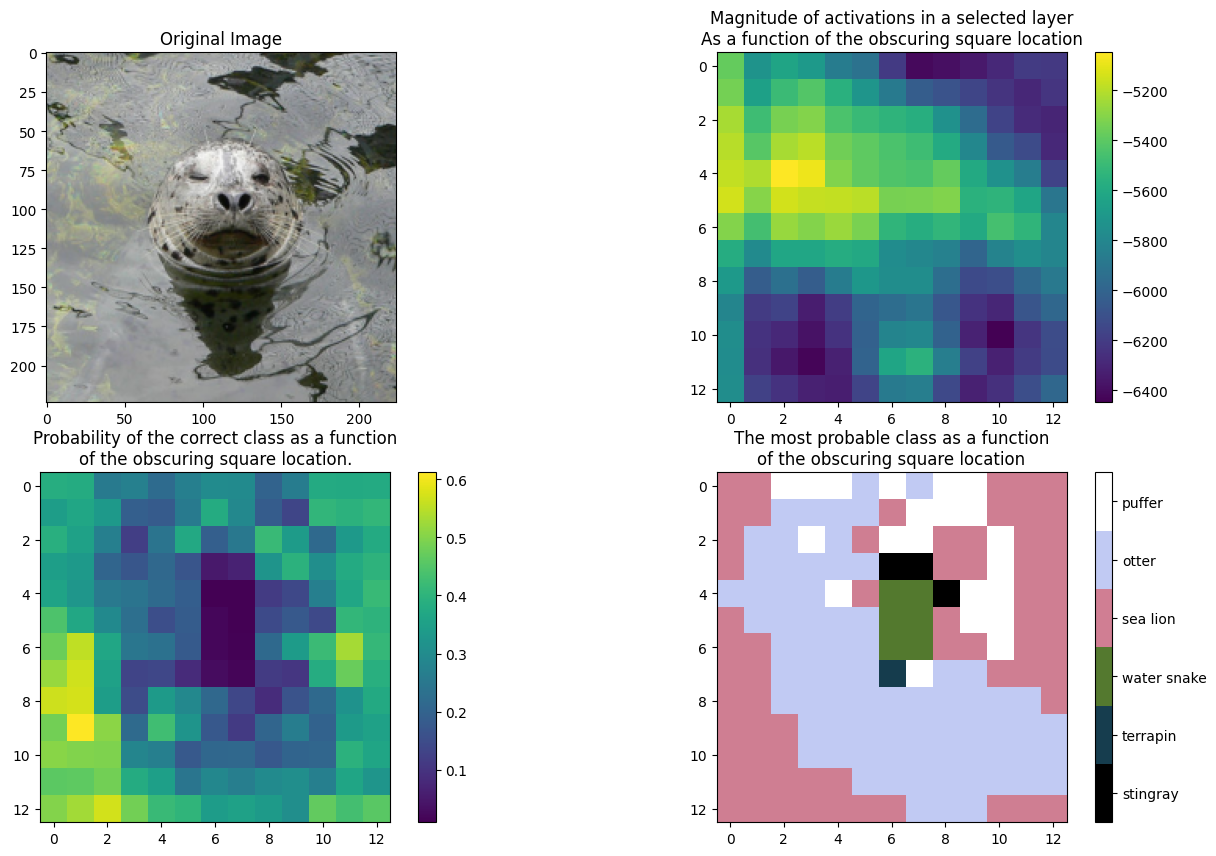

In [ ]:
#
# This image recreates figure 7 from M. Zieler et al.
# Visualizing and Understanding Convolutional Neural Networks
# https://arxiv.org/pdf/1311.2901.pdf
#

plt.figure(figsize(16, 10))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.grid(False)
plt.title("Original Image")

plt.subplot(2, 2, 2)
plt.imshow(maps["heat"], cmap="viridis")
plt.grid(False)
plt.colorbar()
plt.title(
    "Magnitude of activations in a selected layer\n"
    "As a function of the obscuring square location"
)

plt.subplot(2, 2, 3)
plt.imshow(maps["prob"], cmap="viridis")
plt.grid(False)
plt.colorbar()
plt.title(
    "Probability of the correct class as a function\n"
    "of the obscuring square location."
)

plt.subplot(2, 2, 4)
discrete = np.zeros_like(maps["pred"], dtype=np.int64)
values = np.unique(maps["pred"]).astype(np.int64)
for i, v in enumerate(values):
    discrete[np.where(maps["pred"] == v)] = i
num_values = max(values.shape[0], 1)
plt.imshow(discrete, cmap=discrete_cmap(num_values, "cubehelix"))
plt.grid(False)
cb = plt.colorbar(
    ticks=np.arange(
        (num_values - 1.0) / num_values / 2.0,
        num_values,
        (num_values - 1.0) / num_values,
    )[:-1]
)
cb.set_ticklabels([ilsvrc.id_to_desc[v].split(',')[0] for v in values])
plt.title("The most probable class as a function\n" "of the obscuring square location")

## 1.3 [Integrated Gradients](https://arxiv.org/abs/1703.01365)

In [21]:
idx = 16
img = ilsvrc.data[idx][None, ...]
label = ilsvrc.labels[idx]

predicted_id = to_np(vgg.predict(to_tensor(img, cuda=CUDA)))[0][0]

print(
    "Predicted: %s (correct: %s)"
    % (ilsvrc.id_to_desc[predicted_id], ilsvrc.label_to_desc[label])
)

num_integration_points = 300

batch_size = 20

assert (num_integration_points % batch_size) == 0

weights = np.linspace(0.0, 1.0, num_integration_points).astype("float32")[
    :, None, None, None
]
grads = []

for i in range(0, num_integration_points, batch_size):
    # TODO: batch contains a subset of images interpolating between the all gray image and the selected image
    batch = weights[i : i + batch_size] * img + (1.0 - weights[i : i + batch_size]) * (
        np.zeros_like(img) + 0.5)
    batch = to_tensor(batch, cuda=CUDA, requires_grad=True)

    # TODO: Get the probabilities for the correct class
    prediction = torch.sum(
        vgg.probabilities(batch)[:, predicted_id])
    # And backpropagate towards the input
    prediction.backward()
    grads.append(to_np(batch.grad))

grads = np.concatenate(grads, axis=0)

# TODO: compute the pixel importance score
importance_scores = np.sum(np.abs(grads), axis=(0,-1)) / grads.shape[0]

Predicted: axolotl, mud puppy, Ambystoma mexicanum (correct: sea anemone, anemone)


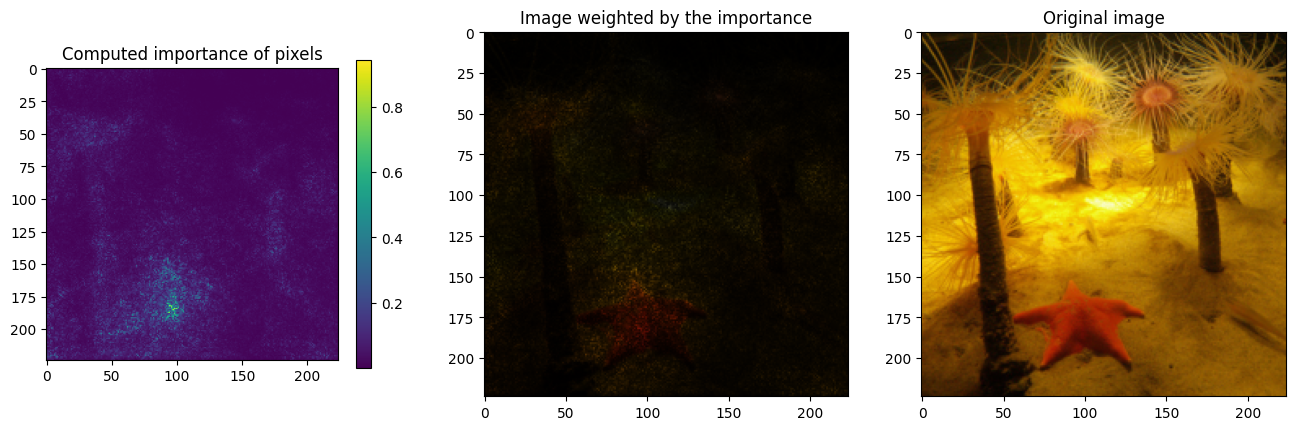

In [24]:
figsize(16, 10)
plt.subplot(1, 3, 1)
plt.imshow(importance_scores, cmap="viridis")
plt.colorbar(shrink=0.4)
plt.title("Computed importance of pixels")
plt.grid(False)

plt.subplot(1, 3, 2)
# normalize the scores to be <=1
w = importance_scores / importance_scores.max()
w = w ** 0.7  # a little gamma correction may make the image prettier
plt.imshow(img[0] * w[:, :, None])
plt.title("Image weighted by the importance")
plt.grid(False)

plt.subplot(1, 3, 3)
plt.imshow(img[0])
plt.title("Original image")
plt.grid(False)

## 1.4 SHAP pixel importances

https://github.com/marcotcr/lime

https://shap.readthedocs.io/en/stable/example_notebooks/image_examples/image_classification/Explain%20an%20Intermediate%20Layer%20of%20VGG16%20on%20ImageNet%20%28PyTorch%29.html

In [ ]:
!pip install lime
!pip install shap

In [ ]:
ilsvrc = ILSVRC2014Sample(100)
idx = 16
to_explain = ilsvrc.data[idx][None, ...]
vgg.eval()

### SHAPE


In [12]:
import shap

In [13]:
e = shap.GradientExplainer((vgg, vgg.features[7]), to_tensor(np.array(ilsvrc.data), cuda=CUDA))
shap_values, indexes = e.shap_values(to_tensor(to_explain, cuda=CUDA), ranked_outputs=2, nsamples=80)

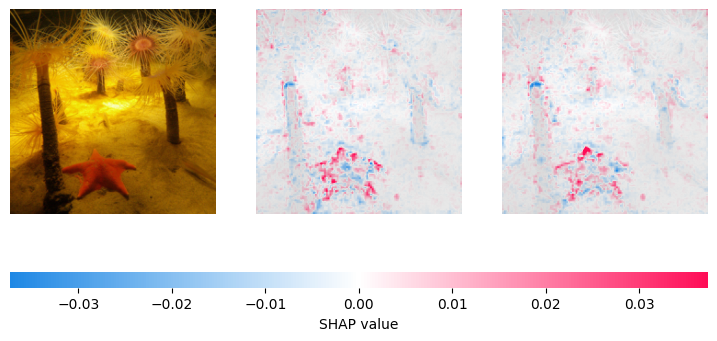

In [14]:
# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap.image_plot(shap_values, to_explain)

### LIME


In [39]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.segmentation import quickshift

In [42]:
def lime_predict(img):
    vgg.eval()
    CUDA = torch.cuda.is_available()
    prob = vgg.probabilities(to_tensor(np.array(img, dtype=np.float32), cuda=CUDA))
    return to_np(prob)
def segmentation_fn(img):
    segments = quickshift(img, kernel_size=3, max_dist=200, ratio=0.2)
    return segments

In [45]:
img = np.array(ilsvrc.data[idx], dtype=np.float64)
# img is the input image
segments = quickshift(img, kernel_size=3, max_dist=200, ratio=0.2)
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img, 
                                         lime_predict,# classification function
                                         top_labels=3,
                                         num_samples=5000) # number of images that will be sent to classification function

  0%|          | 0/5000 [00:00<?, ?it/s]

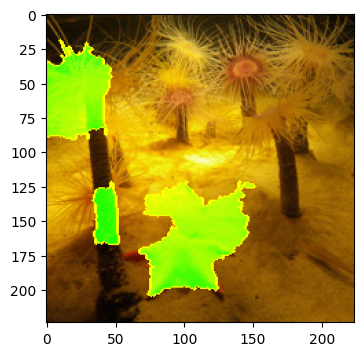

In [46]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5)
img_boundry1 = mark_boundaries(temp, mask)
figsize(4, 4)
plt.imshow(img_boundry1)

## 1.5 Comparison of importance attribution methods

## 1.6 Find image patches that activate selected neurons

In [56]:
num_images = 3
num_patches = 10
layer_name = "conv1_2"
num_neurons = 10
selected_neurons = np.random.choice(num_neurons, size=num_patches)

In [70]:
# Find the most exciting patches for the selected neurons in each image
exciting_patches = []
for img in ilsvrc.data:
    img_tensor = to_tensor(img, cuda=CUDA)
    layer_activations = vgg.layer_activations(img_tensor, layer_name)
    selected_activations = layer_activations[:, selected_neurons, :, :].reshape(-1, 1)
    _, indices = torch.topk(selected_activations[:,0], k=num_images)
    for idx in indices:
        img_patch = img[idx // layer_activations.shape[2], idx % layer_activations.shape[2]]
        exciting_patches.append(img_patch)


IndexError: ignored

In [67]:
selected_neurons

array([9, 8, 3])

In [ ]:
# Compute the gradient with respect to the input for the most exciting patches
gradients = []
for patch in exciting_patches:
    patch_tensor = to_tensor(patch[None], requires_grad=True)
    output = vgg.predict(patch_tensor)
    output[0, output.argmax()].backward()
    gradients.append(to_np(patch_tensor.grad)[0])

In [ ]:
# Normalize the gradients to [0, 1] and display the most exciting patches and gradients
for i in range(num_images):
    fig, axs = plt.subplots(1, num_patches+1, figsize=(12, 3))
    for j in range(num_patches):
        axs[j].imshow(exciting_patches[i*num_patches+j])
        axs[j].axis('off')
        axs[j].set_title("Neuron %d" % selected_neurons[j])
    axs[num_patches].imshow(gradients[i])
    axs[num_patches].axis('off')
    axs[num_patches].set_title("Gradient")
    plt.show()

# Problem 2

## Setup

In [71]:
#![ -d 101_ObjectCategories.tar.gz ] || gdown https://drive.google.com/u/0/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
![ -e 101_ObjectCategories.tar.gz ] || gdown https://drive.google.com/u/0/uc?id=10NIeg2v6b9SzBBkqzbxUT_xTTgzIjsmv
![ -d 101_ObjectCategories ] || tar zxf 101_ObjectCategories.tar.gz

Downloading...
From: https://drive.google.com/u/0/uc?id=10NIeg2v6b9SzBBkqzbxUT_xTTgzIjsmv
To: /content/101_ObjectCategories.tar.gz
100% 132M/132M [00:02<00:00, 44.4MB/s]


In [ ]:
caltech_whole_dataset = torchvision.datasets.ImageFolder("./101_ObjectCategories/")

all_indexes = np.random.permutation(len(caltech_whole_dataset))
train_size = int(len(all_indexes) * 0.8)

caltech_train_dataset = SubsampledImageDataset(
    caltech_whole_dataset,
    all_indexes[:train_size],
    torchvision.transforms.Compose(
        [
            torchvision.transforms.RandomResizedCrop(224),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
        ]
    ),
)

caltech_test_dataset = SubsampledImageDataset(
    caltech_whole_dataset,
    all_indexes[train_size:],
    torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
        ]
    ),
)

caltech_datasets = {
    "train": caltech_train_dataset,
    "test": caltech_test_dataset,
}

In [ ]:
batch_size = 64

caltech_loaders = {
    "train": torch.utils.data.DataLoader(
        caltech_datasets["train"], batch_size=batch_size, num_workers=4, shuffle=True
    ),
    "test": torch.utils.data.DataLoader(
        caltech_datasets["test"], batch_size=batch_size, num_workers=4, shuffle=False
    ),
}

In [ ]:
train_batch = next(iter(caltech_loaders["train"]))
common.plotting.plot_mat(to_np(train_batch[0])[:20])

In [ ]:
print("\nClassifier layers")
print("-----------------")
for layer in vgg.classifier:
    print("{: <12}({}".format(*str(layer).split("(", 1)))

## Task

In [ ]:
# TODO: implement a new classifier using `torch.nn.Sequential` and `torch.nn.Linear`
classifier = TODO

# Replace the classifier of our VGG network
vgg.classifier = classifier

# Disable gradient computation for the all parameter.
# It will speed up the backward pass - the gradient will not be
# backpropagated through the feature extractor.
for p in vgg.parameters():
    p.requires_grad = False

# Reenable gradient computation in our new classifier
for p in vgg.classifier.parameters():
    p.requires_grad = True

criterion = (
    nn.CrossEntropyLoss()
)  # Note: nn.CrossEntropyLoss combines LogSoftmax with NLLLoss

# Train only the params of the classifier
optimizer = torch.optim.Adam(vgg.classifier.parameters(), lr=0.0001)

train(
    vgg, caltech_loaders, optimizer, criterion, num_epochs=10, log_every=50, cuda=True
)